./fig/lab8: Iris 분류  (2 feature -> 3 qubit, 멀티 출력)
  feature idx: [2, 3]  |  N_QUBITS=3  |  N_LAYERS=2
  매핑: [x1, x2, x1*x2]  -> 3번째 큐빗 = 교차항

  feature 이름: ['petal length (cm)', 'petal width (cm)'] + 교차항(x1*x2)
  클래스: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]
  train: 105개, test: 45개
  입력 형상: (105, 3)  (샘플 x 3)


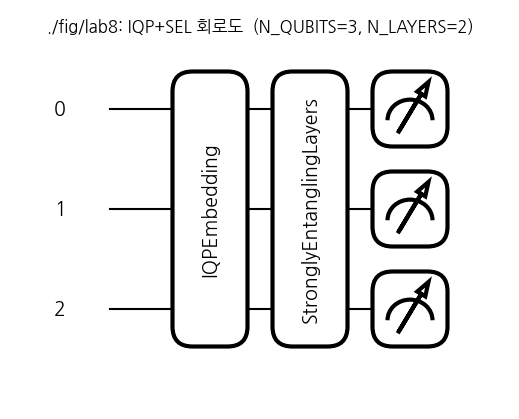

In [1]:
# !pip install pennylane koreanize_matplotlib scikit-learn -q
import pennylane as qml
from pennylane import numpy as np
import numpy as std_np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from IPython.display import clear_output
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# ===== 학생 수정 영역 =====
FEAT_IDX  = [2, 3]   # 사용할 feature 인덱스: [0,1] / [2,3] / [0,2] / [1,3]
N_LAYERS  = 2        # Ansatz 레이어 수: 1 / 2 / 3
N_REPEATS = 1        # IQP 반복 횟수: 1 / 2
STEPS     = 50       # 학습 스텝 수: 30 / 50 / 100
LR        = 0.08     # 학습률: 0.01 / 0.05 / 0.08
# ===== 수정 끝 =====
# ============================================================

N_QUBITS = 3   # feature 2개 + 교차항 1개 -> 고정

print("=" * 60)
print("./fig/lab8: Iris 분류  (2 feature -> 3 qubit, 멀티 출력)")
print("=" * 60)
print(f"  feature idx: {FEAT_IDX}  |  N_QUBITS={N_QUBITS}  |  N_LAYERS={N_LAYERS}")
print(f"  매핑: [x1, x2, x1*x2]  -> 3번째 큐빗 = 교차항")

# ===========================================================
#  1. 데이터 준비
# ===========================================================
iris       = load_iris()
feat_names = [iris.feature_names[i] for i in FEAT_IDX]
X_raw      = iris.data[:, FEAT_IDX]
y          = iris.target

X_scaled = MinMaxScaler((0, std_np.pi)).fit_transform(X_raw)

# 교차항 추가: [x1, x2] -> [x1, x2, x1*x2]
X_aug = std_np.column_stack([
    X_scaled,
    X_scaled[:, 0] * X_scaled[:, 1]
])

X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y, test_size=0.3, stratify=y, random_state=42
)
X_train = np.array(X_train)
X_test  = np.array(X_test)

print(f"\n  feature 이름: {feat_names} + 교차항(x1*x2)")
print(f"  클래스: {list(iris.target_names)}")
print(f"  train: {len(X_train)}개, test: {len(X_test)}개")
print(f"  입력 형상: {X_train.shape}  (샘플 x 3)")

# ===========================================================
#  2. 양자 회로 -- 멀티 출력 (expval x 3)
# ===========================================================
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev)
def circuit(x, w):
    qml.IQPEmbedding(x, wires=range(N_QUBITS), n_repeats=N_REPEATS)
    qml.StronglyEntanglingLayers(w, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

# 회로도 시각화
w_sample = np.array(std_np.random.normal(0, 0.1,
           qml.StronglyEntanglingLayers.shape(N_LAYERS, N_QUBITS)))
fig, _   = qml.draw_mpl(circuit, decimals=2)(X_train[0], w_sample)
fig.suptitle(f"./fig/lab8: IQP+SEL 회로도  (N_QUBITS={N_QUBITS}, N_LAYERS={N_LAYERS})",
             fontsize=12)
fig.savefig("./fig/lab8a.png", dpi=300, bbox_inches="tight")
plt.show()

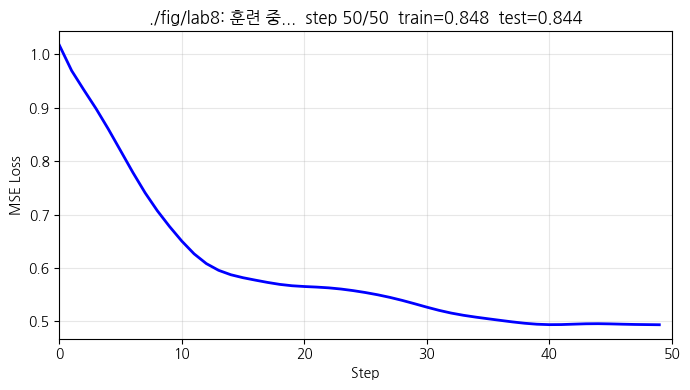


최종 결과
  train Acc: 0.8476
  test  Acc: 0.8444
  파라미터:  18개  (형상: (2, 3, 3))


In [2]:
# ===========================================================
#  3. 학습 -- 단일 가중치 세트, cross-entropy 유사 MSE
# ===========================================================
def one_hot(y, n_class=3):
    oh = std_np.zeros((len(y), n_class))
    for i, c in enumerate(y):
        oh[i, c] = 1.0
    return oh

def cost(w):
    total = np.array(0.0)
    for x, label in zip(X_train, y_train):
        out    = np.array(circuit(x, w))          # shape (3,)
        target = np.array(one_hot([label])[0])    # shape (3,)
        total  = total + np.mean((out - (2 * target - 1)) ** 2)
    return total / len(X_train)

def predict(X, w):
    scores = std_np.array([
        std_np.array(circuit(x, w)) for x in X
    ])                                             # shape (n, 3)
    return std_np.argmax(scores, axis=1)

std_np.random.seed(42)
w_shape = qml.StronglyEntanglingLayers.shape(N_LAYERS, N_QUBITS)
w       = np.array(std_np.random.normal(0, 0.1, w_shape), requires_grad=True)
n_params = int(std_np.prod(w_shape))

print(f"\n  파라미터 형상: {w_shape}  ->  총 {n_params}개")
print(f"  출력: expval(Z0), expval(Z1), expval(Z2)  -> argmax -> 클래스")

opt     = qml.AdamOptimizer(LR)
history = []

for step in range(STEPS):
    w, loss = opt.step_and_cost(cost, w)
    history.append(float(loss))

    if step % 10 == 0 or step == STEPS - 1:
        tr_acc = float(std_np.mean(predict(X_train, w) == y_train))
        te_acc = float(std_np.mean(predict(X_test,  w) == y_test))
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(7, 4))
        ax.plot(history, 'b-', lw=2)
        ax.set_xlabel("Step"); ax.set_ylabel("MSE Loss")
        ax.set_title(f"./fig/lab8: 훈련 중...  step {step+1}/{STEPS}  "
                     f"train={tr_acc:.3f}  test={te_acc:.3f}")
        ax.set_xlim(0, STEPS); ax.grid(True, alpha=0.3)
        plt.tight_layout(); 
        plt.show()

# ===========================================================
#  4. 최종 결과
# ===========================================================
train_acc = float(std_np.mean(predict(X_train, w) == y_train))
test_acc  = float(std_np.mean(predict(X_test,  w) == y_test))

print("\n" + "=" * 60)
print("최종 결과")
print("=" * 60)
print(f"  train Acc: {train_acc:.4f}")
print(f"  test  Acc: {test_acc:.4f}")
print(f"  파라미터:  {n_params}개  (형상: {w_shape})")

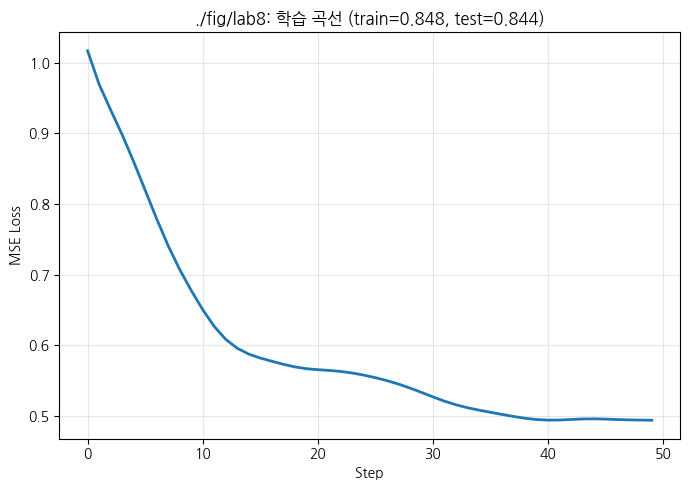

In [3]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(history, lw=2)
ax.set_xlabel("Step")
ax.set_ylabel("MSE Loss")
ax.set_title(f"./fig/lab8: 학습 곡선 (train={train_acc:.3f}, test={test_acc:.3f})")
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig("./fig/lab8b.png", dpi=300, bbox_inches="tight")
plt.show()

NameError: name 'xx' is not defined

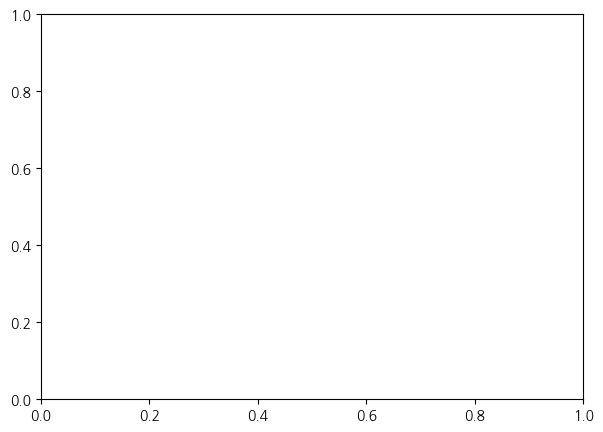

In [4]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')

colors = ['steelblue', 'tomato', 'green']
for c, (name, color) in enumerate(zip(iris.target_names, colors)):
    mask_tr = y_train == c
    mask_te = y_test  == c

    ax.scatter(X_train[mask_tr, 0], X_train[mask_tr, 1],
               c=color, s=30, alpha=0.7, label=f'{name} train')
    ax.scatter(X_test[mask_te, 0],  X_test[mask_te, 1],
               c=color, s=80, marker='*', edgecolors='black',
               label=f'{name} test')

ax.set_xlabel(feat_names[0])
ax.set_ylabel(feat_names[1])
ax.set_title("./fig/lab8: 결정 경계 + 데이터")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig("./fig/lab8f.png", dpi=300, bbox_inches="tight")
plt.show()